<a href="https://colab.research.google.com/github/guardiaum/BERT-SIDE/blob/master/bert_side.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

# Copy/download the file
fid = drive.ListFile({'q':"title='bert-side.ipynb'"}).GetList()[0]['id']
f = drive.CreateFile({'id': fid})
f.GetContentFile('bert-side.ipynb')

In [0]:
# when running on Google Colab
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
!pip install --upgrade git+https://github.com/maxpumperla/hyperas
!pip install --upgrade git+https://github.com/hyperopt/hyperopt

  Cloning https://github.com/maxpumperla/hyperas to /tmp/pip-req-build-uu2dk5zs
  Running command git clone -q https://github.com/maxpumperla/hyperas /tmp/pip-req-build-uu2dk5zs
  Created wheel for hyperas: filename=hyperas-0.4.1-cp36-none-any.whl size=9319 sha256=e8afee9fb3ab87dd48e813cbf02a42d8725cfa3c1ab52f541f2eb883c3852858
  Stored in directory: /tmp/pip-ephem-wheel-cache-kh1f4w93/wheels/6d/2e/06/6dd83c2ea48f7418dd2d901fca3d111fa51f66a87d733e31e9
Successfully built hyperas
  Cloning https://github.com/hyperopt/hyperopt to /tmp/pip-req-build-je032h18
  Running command git clone -q https://github.com/hyperopt/hyperopt /tmp/pip-req-build-je032h18
  Running command git submodule update --init --recursive -q
     |████████████████████████████████| 1.7MB 3.5MB/s 
  Created wheel for docs: filename=docs-0.2.2-cp36-none-any.whl size=986454 sha256=7151bfb44e5152d70e009dbe5faf9419c4d5fa4982dc08dfab64a84f959de199
  Stored in directory: /tmp/pip-ephem-wheel-cache-yhvfn47x/wheels/4a/f1/b1/6716

In [0]:
try:
  # Use the %tensorflow_version magic if in colab.
  %tensorflow_version 2.x
except Exception:
  pass

TensorFlow 2.x selected.


In [0]:
import numpy as np
import pandas as pd
import os, sys, random, argparse
import pickle
from collections import defaultdict as ddict
import tensorflow as tf
#from hyperopt import Trials, STATUS_OK, tpe
#from hyperas import optim
#from hyperas.distributions import choice, uniform, randint
from sklearn import metrics
from sklearn.metrics import precision_recall_curve, average_precision_score
from sklearn.metrics import f1_score
from sklearn.metrics import auc
import matplotlib.pyplot as plt

# Set precision for numpy
np.set_printoptions(precision=4)

seed = 1234

tf.random.set_seed(seed)
random.seed(seed)
np.random.seed(seed)

# path2datafile = "data/gids_bert_processed-test.pkl"
# models_dir = "data/models/"
# results_dir = "data/results/"

In [0]:
root = "/content/drive/My Drive/Doutorado/[DL] Projeto/"
path2datafile = root + "data/gids_bert_processed-test.pkl"
models_dir = root + "models/"
results_dir = root + "results/"
baselines_dir = root + "baselines/"

model_name = 'best_model-12-12'

In [0]:
def padData(data, max_sent_in_bag, max_alias, max_alias_len, subj_max, obj_max, aliases_count):
    dataset = []
    countBags = 0
    
    for i, bag in enumerate(data):
        embeds = bag['embeds']
        aliases = bag['ProbY']
        sub_type = bag['SubType']
        obj_type = bag['ObjType']
        
        # padding embeds
        while len(embeds) != max_sent_in_bag:
            embeds.append(np.zeros(768))
        
        # padding alias
        while len(aliases) != max_sent_in_bag:
            aliases.append([0])
              
        pad_alias = np.zeros((len(aliases), max_alias), np.int32)
        for i, alias in enumerate(aliases):
            pad_alias[i, :len(alias)] = alias[:max_alias]
        
        # padding subject
        while len(sub_type) != subj_max:
            sub_type.append(0)
            
        # padding object
        while len(obj_type) != obj_max:
            obj_type.append(0)
        
        label = bag['Y']
        
        while len(label) > 1:
            label.pop()
        
        dataset.append([embeds, pad_alias, sub_type, obj_type, label])
        countBags += 1
        
    return dataset, countBags, aliases_count
    

def getData(data):
    max_sent_in_bag, max_alias, max_alias_len, subj_max, obj_max, aliases_count = 0, 0, 0, 0, 0, 0 
    
    for i, bag in enumerate(data):
        embeds = bag['embeds']
        aliases = bag['ProbY']
        sub_type = bag['SubType']
        obj_type = bag['ObjType']
        
        max_sent_in_bag = max(max_sent_in_bag, len(embeds))
        
        max_alias = max(max_alias, len(aliases))
        
        for alias in aliases:
            max_alias_len = max(max_alias_len, len(alias))
            for a in alias:
                aliases_count = max(aliases_count, a)
            
        subj_max = max(subj_max, len(sub_type))
        obj_max = max(obj_max, len(obj_type))
    
    return padData(data, max_sent_in_bag, max_alias, max_alias_len, subj_max, obj_max, aliases_count+1)

In [0]:
def data(path2datafile, models_dir, model_name):
    batch_size = 512
    type_dim = 150
    alias_dim = 150
    embedding_dim = 768
    L2 = 0.001
    regularizer = tf.keras.regularizers.l2(l=0.5 * (L2))

    data = pickle.load(open(path2datafile, 'rb'))

    voc2id      = data['voc2id']
    id2voc      = data['id2voc']
    type2id     = data['type2id']
    type_count  = len(data['type2id'])
    num_class   = len(data['rel2id'])
    max_pos = data['max_pos']
    
    print("getData Train")
    train, train_bags, alias_count = getData(data['train'])
    
    print("getData Validation")
    validation, test_bags, alias_count = getData(data['dev'])
    
    print("getData Test")
    test, dev_bags, alias_count = getData(data['test'])
    
    return train, validation, test, embedding_dim, num_class, alias_dim, regularizer, type_count, type_dim, batch_size, alias_count, models_dir, model_name

def get_chunks(data, batch_size):
    count_bags = len(data)
    for indx in range(0, count_bags, batch_size):
        yield data[indx:min(indx + batch_size, count_bags)]
        
def create_batches(data, batch_size=64):
    batches = []
    for chunk in get_chunks(data, batch_size):
        batch = ddict(list)
        num = 0
        
        bert = []
        alias = []
        subj = []
        obj = []
        out = []
        for i, bag in enumerate(chunk):
            bert.append(bag[0])
            alias.append(bag[1])
            subj.append(bag[2])
            obj.append(bag[3])
            out.append(bag[4])
        batches.append([bert, alias, subj, obj, out])
        
    return batches, len(batches)
    
def get_batches(batches):
    while True:
        for batch in batches:
            yield ({'bert_input': np.array(batch[0], dtype='float32'), 
                    'alias': np.array(batch[1], dtype='int32'), 
                    'subj': np.array(batch[2], dtype='int32'), 
                    'obj': np.array(batch[3], dtype='int32')}, 
                   {'output': np.array(batch[4], dtype='int32')})

In [0]:
def model(train, validation, test, embedding_dim, num_class, alias_dim, regularizer, 
          type_count, type_dim, batch_size, max_pos, alias_count, models_dir, model_name):
    
    # embed input
    embed_input = tf.keras.Input(shape=(None, embedding_dim,), name="bert_input", dtype='float32')
    
    # embed alias
    alias_input = tf.keras.Input(shape=(None, None,), name="alias", dtype='int32')
    embed_alias = tf.keras.layers.Embedding(input_dim=alias_count, 
                                            output_dim=alias_dim, trainable=True,
                                            embeddings_initializer=tf.keras.initializers.VarianceScaling(
                                                scale=1.0, mode="fan_avg", distribution="uniform"), 
                                            embeddings_regularizer=regularizer, name='alias_embed')(alias_input)
    
    alias_av = tf.math.reduce_sum(input_tensor=embed_alias, axis=2, keepdims=False, name='alias_mean') / tf.cast(tf.shape(embed_alias)[1], tf.float32)
    
    # sentence representations
    sent_reps = tf.keras.layers.concatenate([embed_input, alias_av], axis=2, name='bert_alias_concat')
    
    
    # Input subj-obj types
    subj_input = tf.keras.layers.Input(shape=(None,), name="subj", dtype='int32')
    obj_input = tf.keras.layers.Input(shape=(None,), name="obj", dtype='int32')
    
    # embed subj-obj types
    embed_type = tf.keras.layers.Embedding(input_dim=type_count, output_dim=type_dim, 
                                           embeddings_regularizer=regularizer,
                                           embeddings_initializer=tf.compat.v1.keras.initializers.VarianceScaling(
                                               scale=1.0, mode="fan_avg", distribution="uniform"), name='type_embed')
    subj_embed = embed_type(subj_input)
    obj_embed = embed_type(obj_input)
    
    # average of types representations
    subj_type_av = tf.math.reduce_mean(input_tensor=subj_embed, axis=1, name='subj_mean')
    obj_type_av = tf.math.reduce_mean(input_tensor=obj_embed, axis=1, name='obj_mean')
    
    # concatenate subject and object to one single representation
    concat_type = tf.keras.layers.concatenate([subj_type_av, obj_type_av], axis=1, name='type_concat')
    
    # weights for querying attention layer 
    # samples are drawn from a uniform distribution within [-limit, limit], with limit = sqrt(3 * scale / n)
    sent_atten_q = tf.keras.initializers.VarianceScaling(scale=1.0, 
                                                         mode="fan_avg", 
                                                         distribution="uniform")(shape=(1, 1, alias_dim+embedding_dim))  # alias_dim+
    
    # Bag Attention sentence level
    bag_attention = tf.keras.layers.Attention(name='attention')([sent_atten_q, sent_reps])
    
    mean_bag_attention = tf.math.reduce_mean(bag_attention, axis=1)
    
    bag_reps = tf.keras.layers.concatenate([mean_bag_attention, concat_type], axis=1, name='bag_rep_type_concat')
    
    # fully connected
    fc1 = tf.keras.layers.Dense(units={{choice([48, 96, 192, 384, 768])}}, 
                                activation="relu", 
                                kernel_regularizer=regularizer, name='fully1')(bag_reps)
    
    drop1 = tf.keras.layers.Dropout(rate={{uniform(0,1)}}, name='drop1')(fc1)
    
    fc2 = tf.keras.layers.Dense(units={{choice([6, 12, 24, 48])}}, 
                                activation="relu", 
                                kernel_regularizer=regularizer, name='fully2')(drop1)
    
    drop = tf.keras.layers.Dropout(rate={{uniform(0,1)}}, name='drop2')(fc2)
    
    # output layer
    label = tf.keras.layers.Dense(num_class, activation='softmax', kernel_regularizer=regularizer, name='output')(drop)
    
    model = tf.keras.Model([embed_input, alias_input, subj_input, obj_input], label)
    
    print(model.summary())
    
    optim = tf.keras.optimizers.SGD(lr={{uniform(0,1)}}, name='SGD')

    model.compile(loss=tf.keras.losses.sparse_categorical_crossentropy,
                  optimizer=optim,
                  metrics=['accuracy'])
    
    train_batches, train_batches_len = create_batches(train, batch_size)
    val_batches, val_batches_len = create_batches(validation, batch_size)
    test_batches, test_batches_len = create_batches(test, batch_size)
    
    checkpointer = tf.keras.callbacks.ModelCheckpoint(filepath=models_dir+ model_name + "es_best.h5", verbose=1, 
                                   save_best_only=True, save_weights_only=True)
    earlystopper = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=40, verbose=1)
    
    history = model.fit_generator(get_batches(train_batches), steps_per_epoch=train_batches_len, 
                        epochs=500, verbose=2, validation_steps=val_batches_len, 
                        validation_data=get_batches(val_batches), callbacks=[checkpointer, earlystopper])
    
    score, acc = model.evaluate_generator(generator=get_batches(test_batches), 
                                          steps=test_batches_len, verbose=0)
    print('Test accuracy:', acc)
    
    return {'loss': -acc, 'status': STATUS_OK, 'model': model, 
            'history.val_loss':history.history['val_loss'], 
            'history.val_acc': history.history['val_accuracy'],
            'history.loss': history.history['loss'], 
            'history.acc': history.history['accuracy']}

In [0]:
# chose better parameters to model
trials = Trials()
best_run, best_model = optim.minimize(model=model,
                                      data=data,
                                      algo=tpe.suggest,
                                      max_evals=10,
                                      trials=trials,
                                      functions=[padData, getData, get_chunks, get_batches, create_batches],
                                      notebook_name='bert-side',
                                      data_args=(path2datafile,models_dir, model_name)
                                      )

print("Best performing model chosen hyper-parameters:")
print(best_run)

tf.keras.utils.plot_model(best_model, to_file=models_dir + model_name + ".png", show_shapes=True, show_layer_names=True)
best_model.save(models_dir + model_name + '.h5')

best_trial_ = trials.best_trial

acc = best_trial_.get('result').get('history.acc')
loss = best_trial_.get('result').get('history.loss')
val_acc = best_trial_.get('result').get('history.val_acc')
val_loss = best_trial_.get('result').get('history.val_loss')

df = pd.DataFrame.from_dict({'acc':acc, 'loss': loss, 'val_acc': val_acc, 'val_loss': val_loss})

df.to_pickle(results_dir + 'trainHistory.pkl')

>>> Imports:
#coding=utf-8

try:
    from pydrive.auth import GoogleAuth
except:
    pass

try:
    from pydrive.drive import GoogleDrive
except:
    pass

try:
    from google.colab import auth
except:
    pass

try:
    from oauth2client.client import GoogleCredentials
except:
    pass

try:
    from google.colab import drive
except:
    pass

try:
    import numpy as np
except:
    pass

try:
    import pandas as pd
except:
    pass

try:
    import os, sys, random, argparse
except:
    pass

try:
    import pickle
except:
    pass

try:
    from collections import defaultdict as ddict
except:
    pass

try:
    import tensorflow as tf
except:
    pass

try:
    from hyperopt import Trials, STATUS_OK, tpe
except:
    pass

try:
    from hyperas import optim
except:
    pass

try:
    from hyperas.distributions import choice, uniform, randint
except:
    pass

try:
    from sklearn import metrics
except:
    pass

try:
    from sklearn.metrics import precision_recall_curve, average_p

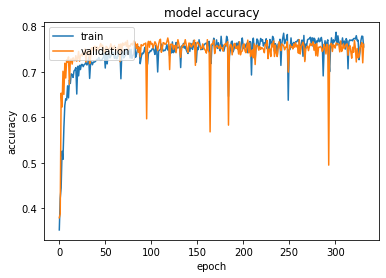

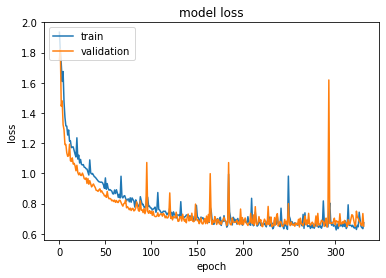

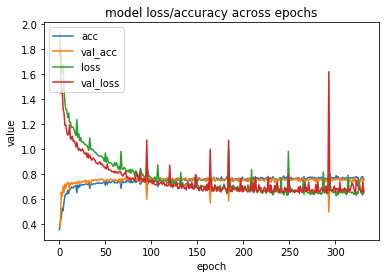

In [0]:
preds 	  = pickle.load(open(results_dir + 'trainHistory.pkl', 'rb'))
acc 	   	= preds['acc']
val_acc 	= preds['val_acc']
loss 	   	= preds['loss']
val_loss 	= preds['val_loss']
 
# summarize history for accuracy
plt.plot(acc)
plt.plot(val_acc)
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(loss)
plt.plot(val_loss)
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

# 
plt.plot(acc)
plt.plot(val_acc)
plt.plot(loss)
plt.plot(val_loss)
plt.title('model loss/accuracy across epochs')
plt.ylabel('value')
plt.xlabel('epoch')
plt.legend(['acc', 'val_acc', 'loss', 'val_loss'], loc='upper left')
plt.show()

In [0]:
def split_label(dataset):
    batches = []
    labels = []
    for d in dataset:
        batches.append([np.array(d[0], dtype='float32'), np.array(d[1], dtype='int32'), 
                        np.array(d[2], dtype='int32'), np.array(d[3], dtype='int32')])
        labels.append(d[4])
        
    return np.array(batches), np.array(labels)

def getPdata(data):
    
    p_one = []
    p_two = []
    
    for bag in data['test']:
        if len(bag['X']) < 2: continue
        
        indx = list(range(len(bag['X'])))
        random.shuffle(indx)
        
        p_one.append({
            'embeds':   [bag['embeds'][indx[0]]],
            'ProbY': 	[bag['ProbY'][indx[0]]],
            'Y':    	bag['Y'],
            'SubType':	bag['SubType'],
            'ObjType':	bag['ObjType']
        })

        p_two.append({
            'embeds':   [bag['embeds'][indx[0]], bag['embeds'][indx[1]]],
            'ProbY': 	[bag['ProbY'][indx[0]], bag['ProbY'][indx[1]]],
            'Y':   	 	bag['Y'],
            'SubType':	bag['SubType'],
            'ObjType':	bag['ObjType']
        })
    
    
    return getData(p_one), getData(p_two)


def getPscore(p_n_data):
    
    data_one, y_true = split_label(p_n_data)

    y_pred_indx = []
    y_pred_prob = []
    for bert, alias, subj, obj in data_one:
        prediction = model.predict([[bert], [alias], [subj], [obj]])
        y_pred_indx.append(np.argmax(prediction))
        y_pred_prob.append(np.amax(prediction))
    
    y_pred_indx = np.array(y_pred_indx)
    y_prob = np.reshape(np.array(y_pred_prob), (-1))
    y_true = np.reshape(np.array(y_true), (-1))
    order = np.argsort(-y_prob)
    
    def p_score(n):
        sum_correct_pred = 0.0
        for i in order[:n]:
            sum_correct_pred += 1.0 if (y_true[i] == y_pred_indx[i]) else 0
        return sum_correct_pred / n
        
    return p_score(100), p_score(200), p_score(300)

def savePredictions2File(dataset_name, algorithm_name, data):
    validation, count_bags, alias_count = getData(data['test'])
    classes_ = len(data['rel2id'])
    
    data, y_true = split_label(validation)

    logit_list = []
    for bert, alias, subj, obj in data:
        logit_list.append((model.predict([[bert], [alias], [subj], [obj]])[0]).tolist())

    y_flatten = y_true.flatten().tolist()
    y_actual_hot = (tf.keras.utils.to_categorical(y_flatten, num_classes=classes_)).tolist()
    
    pickle.dump({'logit_list': logit_list, 'y_hot': y_actual_hot}, 
                open(results_dir + "{}/{}/precision_recall.pkl".format(dataset_name, algorithm_name), 'wb'))

In [0]:
def getPRData4BERTSIDE():
  model = tf.keras.models.load_model(models_dir + model_name + '.h5')

  data = pickle.load(open(path2datafile, 'rb'))

  validation, count_bags, _ = getData(data['test'])

  data, y_true = split_label(validation)

  y_pred = []
  y_scores = []
  for bert, alias, subj, obj in data:
    score = model.predict([[bert], [alias], [subj], [obj]])
    y_scores.append(score[0].tolist())
    y_pred.append(np.argmax(score))

  y_pred = np.array(y_pred)
  print(y_pred.shape)

  y_flatten = y_true.flatten().tolist()
  y_true = (tf.keras.utils.to_categorical(y_flatten, num_classes=5)).tolist()

  y_hot 	   	= np.array(y_true)
  logit_list 	= np.array(y_scores)

  y_hot_new       = np.reshape(np.array([x[1:] for x in y_hot]), (-1))
  logit_list_new  = np.reshape(np.array([x[1:] for x in logit_list]), (-1))

  return y_hot_new, logit_list_new

def getPRCurveAndAUC(y_hot, logit_list):
  precision, recall, thresholds = precision_recall_curve(y_hot, logit_list)
  area_under = average_precision_score(y_hot, logit_list)
  return precision, recall, thresholds, area_under

def loadBaselinesData(path):
	preds 	   	= pickle.load(open(path, 'rb'))
	y_hot 	   	= np.array(preds['y_hot'])
	logit_list 	= np.array(preds['logit_list'])
	y_hot_new       = np.reshape(np.array([x[1:] for x in y_hot]),      (-1))
	logit_list_new  = np.reshape(np.array([x[1:] for x in logit_list]), (-1))
	return y_hot_new, logit_list_new

/tensorflow-2.0.0/python3.6/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


(3239,)
BERT-SIDE auc=0.819


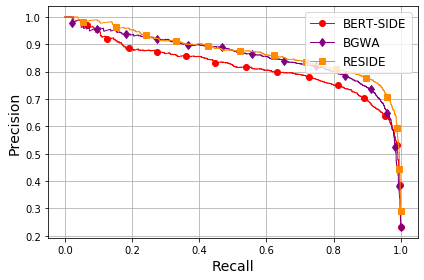

In [0]:
y_hot, logit_list = getPRData4BERTSIDE()
precision, recall, thresholds, area_under = getPRCurveAndAUC(y_hot, logit_list)

# summarize scores
print('BERT-SIDE auc=%.3f' % (area_under))

# plot the precision-recall curves for BERT-SIDE
plt.plot(recall[:], precision[:], marker='o',  color='red' ,label='BERT-SIDE', markevery = 0.1, ms = 6,  lw=1)

y_hot, logit_list = loadBaselinesData(baselines_dir + "BGWA/precision_recall.pkl")
precision, recall, thresholds, area_under = getPRCurveAndAUC(y_hot, logit_list)
plt.plot(recall[:], precision[:], marker='d', color='purple' ,label='BGWA', markevery = 0.1, ms = 6,  lw=1)

y_hot, logit_list = loadBaselinesData(baselines_dir + "RESIDE/precision_recall.pkl")
precision, recall, thresholds, area_under = getPRCurveAndAUC(y_hot, logit_list)
plt.plot(recall[:], precision[:], marker='s', color='darkorange' , label='RESIDE', markevery = 0.1, ms = 6,  lw=1)

# axis labels
plt.xlabel('Recall', fontsize=14)
plt.ylabel('Precision', fontsize=14)
# show the legend
plt.legend(loc="upper right", prop = {'size' : 12})
plt.grid(True)
plt.tight_layout()
plt.show()

#plot_path = './results/{}/plot_pr.png'.format(dataset)
#plt.savefig(plot_path)
#print('Precision-Recall plot saved at: {}'.format(plot_path))


In [0]:
model = tf.keras.models.load_model(models_dir + model_name + '.h5')

data = pickle.load(open(path2datafile, 'rb'))

print("Save data to plot precision-recall curve")

savePredictions2File("gids", "BERT-SIDE", data)

print("precision_recall.pkl created")

print("\nP@N results")

one_, two_ = getPdata(data)

one, one_bags_count, _ = one_
two, two_bags_count, _ = two_

print('=============== test one =============================')
one_100, one_200, one_300 = getPscore(one)
print("P@100: {}, P@200: {}, P@300: {}".format(one_100, one_200, one_300))

print('=============== test two =============================')
two_100, two_200, two_300 = getPscore(two)
print("P@100: {}, P@200: {}, P@300: {}".format(two_100, two_200, two_300))

print('=============== test all =============================')
all_, count_bags, _ = getData(data['test'])
all_100, all_200, all_300 = getPscore(all_)
print("P@100: {}, P@200: {}, P@300: {}".format(all_100, all_200, all_300))

/tensorflow-2.0.0/python3.6/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Save data to plot precision-recall curve
precision_recall.pkl created

P@N results
=============== test one =============================
P@100: 1.0, P@200: 0.99, P@300: 0.9533333333333334
=============== test two =============================
P@100: 1.0, P@200: 0.995, P@300: 0.99
=============== test all =============================
P@100: 1.0, P@200: 1.0, P@300: 1.0


In [0]:
print("\n= P @ ONE ==============================================================\n")

# P@ONE
data_one, y_true = split_label(one)

y_pred = []
for bert, alias, subj, obj in data_one:
    y_pred.append(np.argmax(model.predict([[bert], [alias], [subj], [obj]])))

y_pred = np.array(y_pred)
print(y_pred.shape)

print(metrics.confusion_matrix(y_true, y_pred))

print(metrics.classification_report(y_true, y_pred, digits=3))

print("Precision: %.4f" % metrics.precision_score(y_true, y_pred, average='macro'))
print("Recall: %.4f" % metrics.recall_score(y_true, y_pred, average='macro'))

print("\n= P @ TWO ==============================================================\n")

# P@TWO
data_two, y_true = split_label(two)

y_pred = []
for bert, alias, subj, obj in data_two:
    y_pred.append(np.argmax(model.predict([[bert], [alias], [subj], [obj]])))
    
y_pred = np.array(y_pred)
print(y_pred.shape)

print(metrics.confusion_matrix(y_true, y_pred))

print(metrics.classification_report(y_true, y_pred, digits=3))

print("Precision: %.4f" % metrics.precision_score(y_true, y_pred, average='macro'))
print("Recall: %.4f" % metrics.recall_score(y_true, y_pred, average='macro'))

print("\n= P @ ALL ==============================================================\n")

# P@ALL

validation, count_bags, _ = getData(data['test'])

data, y_true = split_label(validation)

y_pred = []
for bert, alias, subj, obj in data:
    y_pred.append(np.argmax(model.predict([[bert], [alias], [subj], [obj]])))

y_pred = np.array(y_pred)
print(y_pred.shape)

print(metrics.confusion_matrix(y_true, y_pred))

print(metrics.classification_report(y_true, y_pred, digits=3))

print("Precision: %.4f" % metrics.precision_score(y_true, y_pred, average='macro'))
print("Recall: %.4f" % metrics.recall_score(y_true, y_pred, average='macro'))

In [0]:
%matplotlib inline
import collections
import matplotlib.pyplot as plt

data = pickle.load(open(path2datafile, 'rb'))

bagTest = list()

for d in data['test']:
    bagTest.append(len(d['X']))


counter=collections.Counter(bagTest)

print(counter)
    
plt.bar(counter.keys(), counter.values())
plt.ylabel('Bags Count')
plt.xlabel('Bags Size')
plt.title('Bags Size on Test Set')

plt.show()

2204


(array([252., 328., 403., 293., 188., 197., 190., 118.,  67., 168.]),
 array([0.5002, 0.5502, 0.6001, 0.6501, 0.7001, 0.75  , 0.8   , 0.85  ,
        0.8999, 0.9499, 0.9999]),
 <a list of 10 Patch objects>)

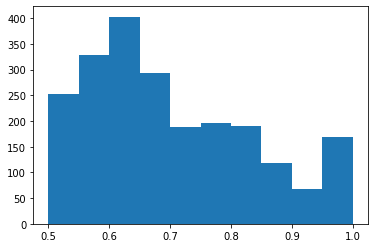

In [0]:
y_hot, logit_list = loadBaselinesData(results_dir + "gids/BERT-SIDE/precision_recall.pkl")

print(len(logit_list[logit_list > 0.5].tolist()))

plt.hist(logit_list[logit_list > 0.5])

2060


(array([142., 158., 185., 166., 183., 242., 234., 257., 286., 207.]),
 array([0.5001, 0.5496, 0.599 , 0.6485, 0.698 , 0.7475, 0.797 , 0.8464,
        0.8959, 0.9454, 0.9949]),
 <a list of 10 Patch objects>)

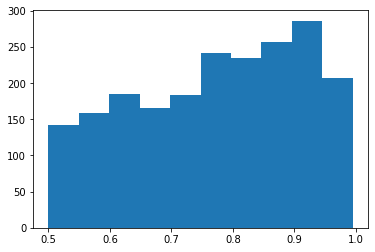

In [0]:
y_hot, logit_list = loadBaselinesData(baselines_dir + "RESIDE/precision_recall.pkl")

print(len(logit_list[logit_list > 0.5].tolist()))

plt.hist(logit_list[logit_list > 0.5])